<h1>Test Code</h1>

<h2>Import the libraries</h2>

In [2]:
!pip install opencv-python imgbeddings psycopg2-binary
import shutil
import cv2
import numpy as np
from imgbeddings import imgbeddings
from PIL import Image
import os
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

Defaulting to user installation because normal site-packages is not writeable


/home/theo/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
face_type = "chimps"

<h2>Load the face detection algorithm</h2>

In [4]:
# change the path according to your file system
haar_cascade = cv2.CascadeClassifier("/home/theo/Documents/Unif/Master/ChimpRec/Human Recognizer/haarcascade_frontalface_default.xml") 

<h2>Isolate the detected faces</h2>

In [5]:
src_img = cv2.imread(f"{face_type}/dataset/Pasted image 1.png", 0)
src_img_grey = cv2.cvtColor(src_img, cv2.COLOR_RGB2BGR)

faces = haar_cascade.detectMultiScale(
    src_img_grey,
    scaleFactor=1.05,
    minNeighbors=1,
    minSize=(150, 150)# to adjust (40, 40) (250, 250)
)

i = 0

cropped_faces = []

if os.path.exists("stored-faces"):
    shutil.rmtree("stored-faces")
os.makedirs("stored-faces/")

for x, y, w, h in faces:
    cropped = src_img[y: y+h, x : x+w]
    cropped_faces.append(cropped)
    target_file_name = "stored-faces/" + str(i) + ".jpg"
    cv2.imwrite(
        target_file_name,
        cropped
    )
    i+=1

<h2>Compute the embedding vectors of the isolated faces</h2>

In [6]:
face_folder = "stored-faces"
ibed = imgbeddings()

/home/theo/.local/lib/python3.12/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'cached_download' (from 'huggingface_hub.file_download') is deprecated and will be removed from version '0.26'. Use `hf_hub_download` instead.
  warnings.warn(warning_message, FutureWarning)
/home/theo/.local/lib/python3.12/site-packages/huggingface_hub/file_download.py:672: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(
2024-10-09 16:51:39.268989: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-09 16:51:39.494239: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical 

In [7]:
embeddings = []

for filename in os.listdir(face_folder):
    img = Image.open(f"{face_folder}/{filename}")
    embedding = ibed.to_embeddings(img)
    embeddings.append(embedding)

if (len(embeddings) > 0):
    embeddings = np.array(embeddings).reshape(len(embeddings), -1)

In [8]:
print(embeddings[0])

[ 3.00634921e-01 -1.05803236e-01 -8.86631981e-02 -5.58214605e-01
 -4.71031010e-01 -1.20703593e-01 -3.21244359e-01 -7.99494386e-01
  5.87916374e-01 -1.52804285e-01 -1.44097343e-01  1.32302448e-01
  3.92754495e-01 -6.93949938e-01  1.49287319e+00  7.19756544e-01
  4.95302290e-01  2.12205619e-01 -4.94921654e-01  7.58435950e-02
 -5.78770787e-02  6.14296556e-01 -5.16129851e-01  5.17297626e-01
 -2.29935735e-01  7.16248393e-01 -1.98770285e-01  4.47591126e-01
  7.99715996e-01  1.38137329e+00 -1.24943852e-01 -1.96313739e-01
  5.47763348e-01 -5.79279661e-03  1.40107408e-01 -2.90672868e-01
 -1.75128728e-02  1.35341501e+00 -2.82790542e-01  1.99336648e-01
  6.43359244e-01  1.32416248e-01 -4.41448122e-01 -1.57351708e+00
 -1.04482043e+00  1.69695914e-01 -3.41548592e-01 -1.16304353e-01
  8.78627360e-01  8.82235408e-01 -1.26617682e+00  6.16159439e-01
  1.65607825e-01  9.60751534e-01  8.46680641e-01  7.02554643e-01
 -1.10184383e+00  9.34845507e-02  1.76334009e-02 -2.44130939e-01
 -3.41375709e-01 -2.01966

<h2>Compute the embeddings of the labelized person.</h2>

In [9]:
known_embeddings = {}

for filename in os.listdir(f"{face_type}/dataset"):
    name = filename.split(".")[0]
    img = Image.open(os.path.join(f"{face_type}/dataset", filename))
    embedding = ibed.to_embeddings(img)
    known_embeddings[name] = embedding

<h2>Compare the computed embeddings to the known embeddings</h2>

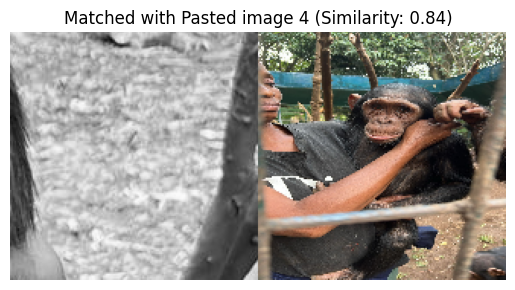

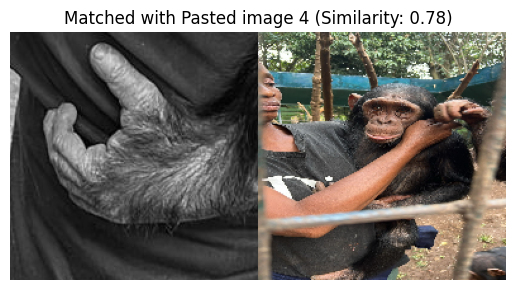

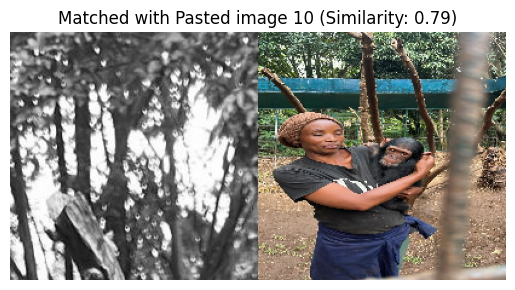

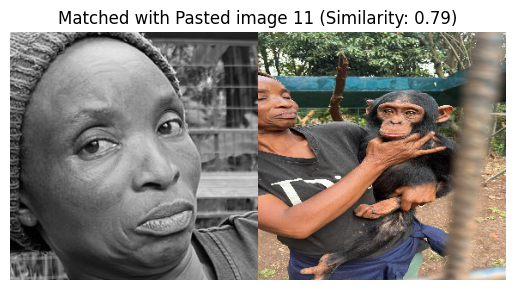

In [10]:
n_matched = 0

for index, embed in enumerate(embeddings):
    best_sim = (0, "nobody")
    for name, known_embed in known_embeddings.items():
        # Ensure known embedding is reshaped to 2D for comparison
        sim = cosine_similarity(embed.reshape(1, -1), known_embed.reshape(1, -1))[0][0]
        if sim > best_sim[0] and sim > 0.2:
            best_sim = (sim, name)

    if best_sim[0] > 0:
        cropped = cropped_faces[index]
        if len(cropped.shape) == 2:
            cropped = cv2.cvtColor(cropped, cv2.COLOR_GRAY2BGR)
        guessed = cv2.imread(f"{face_type}/dataset/{best_sim[1]}.png")
        guessed_resized = cv2.resize(guessed, (cropped.shape[1], cropped.shape[0]))
        side_by_side = np.concatenate((cropped, guessed_resized), axis=1)
        side_by_side_rgb = cv2.cvtColor(side_by_side, cv2.COLOR_BGR2RGB)
        plt.imshow(side_by_side_rgb)
        plt.title(f"Matched with {best_sim[1]} (Similarity: {best_sim[0]:.2f})")
        plt.axis('off')
        plt.show()
        n_matched += 1

if n_matched == 0: print("no match for this picture")